<a href="https://colab.research.google.com/github/jihun0423/NLP/blob/main/Embedding_%26_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
sentences = ['I love my dog.',
             'I do not love my cat.',
             'I love my dog and love my cat',
             'You love my dog!',
             'My dog is not amazing',
             'Do you think my dog is amazing?',
             'I do not love my dog',
             'Do you hate my dog?',
             'I hate my dog',
             'I do not hate my dog']

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_index

{'my': 1,
 'dog': 2,
 'i': 3,
 'love': 4,
 'do': 5,
 'not': 6,
 'you': 7,
 'hate': 8,
 'cat': 9,
 'is': 10,
 'amazing': 11,
 'and': 12,
 'think': 13}

In [4]:
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', truncating='post')

In [5]:
padded

array([[ 3,  4,  1,  2,  0,  0,  0,  0],
       [ 3,  5,  6,  4,  1,  9,  0,  0],
       [ 3,  4,  1,  2, 12,  4,  1,  9],
       [ 7,  4,  1,  2,  0,  0,  0,  0],
       [ 1,  2, 10,  6, 11,  0,  0,  0],
       [ 5,  7, 13,  1,  2, 10, 11,  0],
       [ 3,  5,  6,  4,  1,  2,  0,  0],
       [ 5,  7,  8,  1,  2,  0,  0,  0],
       [ 3,  8,  1,  2,  0,  0,  0,  0],
       [ 3,  5,  6,  8,  1,  2,  0,  0]], dtype=int32)

In [6]:
labels = [1,0,1,1,0,1,0,0,0,1]

In [7]:
padded=torch.LongTensor(padded)

In [8]:
test = ['I hate my cat',
        'I do not hate my cat',
        'I love my cat',
        'I think I love my cat',
        'I think I hate my cat']

In [9]:
test_labels = torch.LongTensor([0,1,1,1,0])

In [10]:
test_sequences = tokenizer.texts_to_sequences(test)
padded_test = pad_sequences(test_sequences, padding='post', truncating='post')

In [11]:
padded_test

array([[ 3,  8,  1,  9,  0,  0],
       [ 3,  5,  6,  8,  1,  9],
       [ 3,  4,  1,  9,  0,  0],
       [ 3, 13,  3,  4,  1,  9],
       [ 3, 13,  3,  8,  1,  9]], dtype=int32)

In [12]:
from torch.utils.data import (DataLoader, TensorDataset)

train_dataset = TensorDataset(torch.LongTensor(padded),torch.LongTensor(labels))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1)

In [13]:
vocab_size = len(word_index)+1
embed_size = 20
hidden_size = 5


In [68]:
class RNN(nn.Module):
  def __init__(self,vocab_size,input_size,hidden_size,batch_first=True):
    super(RNN,self).__init__()
    self.embedding = nn.Embedding(vocab_size,input_size)
    self.rnn = nn.RNN(input_size,hidden_size,batch_first=True)
    self.linear = nn.Linear(hidden_size,2)

  def forward(self,x):
    embedded = self.embedding(x)
    output,hidden = self.rnn(embedded)
    output_1 = self.linear(output[:,-1,:])
    return output_1 # ,output.shape,hidden.shape, output[:,-1,:]  ,x.shape, embedded.shape, hidden.shape

In [46]:
class lstm(nn.Module):
  def __init__(self,vocab_size,input_size,hidden_size,batch_first=True):
    super(lstm,self).__init__()
    self.embedding = nn.Embedding(vocab_size,input_size)
    self.rnn = nn.LSTM(input_size,hidden_size,batch_first=True,bidirectional=True)
    self.linear = nn.Linear(hidden_size*2,2)

  def forward(self,x):
    embedded = self.embedding(x)
    output,(hidden,cell) = self.rnn(embedded)
    output_1 = self.linear(output[:,-1,:])
    return output_1 # ,output.shape,hidden.shape, output[:,-1,:]  ,x.shape, embedded.shape, hidden.shape

In [69]:
model = RNN(vocab_size,embed_size,hidden_size)
model(padded)

tensor([[-1.6855,  0.3661],
        [-1.6563,  0.3570],
        [-1.5651,  0.3183],
        [-1.6854,  0.3661],
        [-1.6755,  0.3657],
        [-1.5224,  0.3521],
        [-1.6525,  0.3596],
        [-1.6831,  0.3664],
        [-1.6855,  0.3661],
        [-1.6561,  0.3603]], grad_fn=<AddmmBackward0>)

In [48]:
model = lstm(vocab_size,embed_size,hidden_size)
model(padded)

tensor([[0.3447, 0.3590],
        [0.3483, 0.3592],
        [0.1870, 0.1273],
        [0.3449, 0.3587],
        [0.3410, 0.3507],
        [0.2947, 0.3626],
        [0.3126, 0.3758],
        [0.3296, 0.3651],
        [0.3444, 0.3581],
        [0.3079, 0.3760]], grad_fn=<AddmmBackward0>)

In [70]:
model = RNN(vocab_size,embed_size,hidden_size)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(),lr=0.001)


In [52]:
labels  = torch.LongTensor(labels)

In [72]:
train_loss = []
valid_loss = []
from tqdm import tqdm

for epoch in tqdm(range(50)):
  optimizer.zero_grad()

  output = model(padded)
  loss = loss_function(output,labels)

  train_loss.append(loss.item())

  with torch.no_grad():
    valid_loss.append(loss_function(model(torch.LongTensor(padded_test)),test_labels).item())

  loss.backward()
  optimizer.step()

  if epoch %10 == 0:
    print('\n',epoch,' : ',loss)


 84%|████████▍ | 42/50 [00:00<00:00, 204.62it/s]


 0  :  tensor(0.7129, grad_fn=<NllLossBackward0>)

 10  :  tensor(0.6746, grad_fn=<NllLossBackward0>)

 20  :  tensor(0.6516, grad_fn=<NllLossBackward0>)

 30  :  tensor(0.6382, grad_fn=<NllLossBackward0>)

 40  :  tensor(0.6286, grad_fn=<NllLossBackward0>)


100%|██████████| 50/50 [00:00<00:00, 204.35it/s]


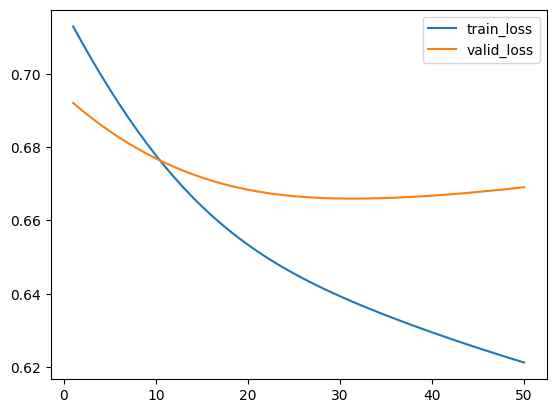

In [73]:
plt.subplots()
epochs = range(1, len(train_loss) + 1)
plt.plot(list(epochs),train_loss,label = 'train_loss')
plt.plot(list(epochs),valid_loss,label = 'valid_loss')
plt.legend()

In [80]:
model = LSTM(vocab_size,embed_size,hidden_size)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(),lr=0.1)

In [81]:
train_loss = []
valid_loss = []
from tqdm import tqdm

for epoch in tqdm(range(10)):
  optimizer.zero_grad()

  output = model(padded)
  loss = loss_function(output,labels)

  train_loss.append(loss.item())

  with torch.no_grad():
    valid_loss.append(loss_function(model(torch.LongTensor(padded_test)),test_labels).item())

  loss.backward()
  optimizer.step()

  if epoch %10 == 0:
    print('\n',epoch,' : ',loss)

100%|██████████| 10/10 [00:00<00:00, 161.99it/s]


 0  :  tensor(0.7247, grad_fn=<NllLossBackward0>)


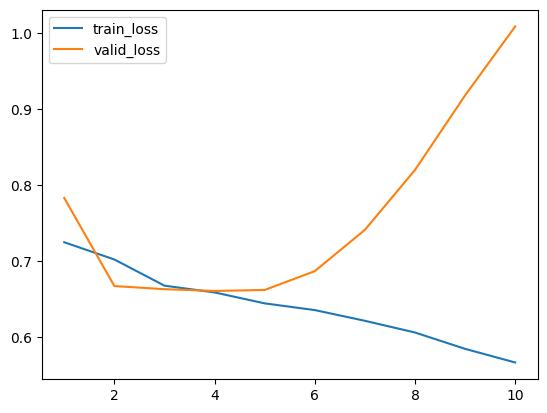

In [82]:
plt.subplots()
epochs = range(1, len(train_loss) + 1)
plt.plot(list(epochs),train_loss,label = 'train_loss')
plt.plot(list(epochs),valid_loss,label = 'valid_loss')
plt.legend()

In [83]:
with torch.no_grad():
  print('valid loss : ',loss_function(model(torch.LongTensor(padded_test)),test_labels).item())
  print('labels : ',model(torch.LongTensor(padded_test)).max(1)[1])

valid loss :  1.086639165878296
labels :  tensor([0, 1, 0, 1, 1])


In [ ]:
tf.argmax(model(torch.LongTensor(padded_test)).detach().numpy(),1)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 0, 1, 1])>

In [ ]:
model(torch.LongTensor(padded_test)).max(1)[1]

tensor([0, 1, 0, 1, 1])